
# Тема 18. Распределение деталей по классам

Взята из "Список примерных тем" https://drive.google.com/file/d/1JSvNRD_QzE0sEhfs6eL7CWGIbccK9JZs/view?usp=sharing

Необходимо научить нейронную сеть определять предметы из предоставленного датасета

База https://www.kaggle.com/nolewit/simple-images-dataset

# Обзор набора данных, простая загрузка

# Libraryes

In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv2D,  MaxPooling2D, GlobalMaxPooling2D # Базовые слови
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотекиДаimage для работы с изображениями
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, LambdaCallback, LearningRateScheduler
from tensorflow.keras.utils import plot_model
import numpy as np # Импортируем библиотеку numpy
import random
import shutil
import time
import os # Импортируем библиотеку os для раоты с файловой системой
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from PIL import Image, ImageEnhance # импортируем модель Image для работы с изображениями

In [ ]:
if os.path.exists('/content/images'): shutil.rmtree('/content/images')
! unzip -q /content/drive/MyDrive/dip/train1.zip -d /content/images/
! unzip -q /content/drive/MyDrive/dip/train2.zip -d /content/images/
!rm /content/images/bea/15608.png    # битый

In [ ]:
class DataLoader():
  def __init__(self, path):
    self.path = path
    self.clName = sorted(os.listdir(path))

  def loadImgFile(self, fPath):           # Загрузка изображения из файла
    return np.array(image.load_img(fPath)).astype('float32')/255    # изображение в виде массива  0 - 1.

  def loadImages(self, ncl):              # Загрузка класса
    for n, imfile in enumerate(os.listdir(self.path + self.clName[ncl])):  #  для каждого изображения  

      img = self.loadImgFile(os.path.join(self.path + self.clName[ncl], imfile))

      xTrain.append(img)           # добавим в список обуч.  
      yTrain.append(ncl)


  def loadDataSet(self):      # Загрузка изображений
    for nc in range(len(self.clName)):
      self.loadImages(nc)     # загрузим избражениЯ
      print(self.clName[nc], end = '   ')

    return self.clName

dl = DataLoader('/content/images/')
xTrain,xTest, yTrain,yTest = [],[], [],[]
print('Поехали:') 
className = dl.loadDataSet()
del dl

nClasses = len(className)
xTrain = np.array(xTrain)
#xTest = np.array(xTest)
yTrain = utils.to_categorical(yTrain, nClasses)
#yTest = utils.to_categorical(yTest, nClasses)

print(xTrain.shape, yTrain.shape)  

Поехали:
bag   bal   ban   bea   can   env   gbt   mon   pbt   toy   (74791, 71, 71, 3) (74791, 10)


In [ ]:
n = 10 # Количество выводимых случайных картинок
fig, axs = plt.subplots(n, n, figsize=(24, 24)) # Создаем полотно из n*n графиков
for i in range(n): # Проходим по классам
  label_indexes = np.where(np.argmax(yTrain, axis=1)==i%10)[0] # Получаем список из индексов положений класса 
  for j in range(n):
    indx = random.choice(label_indexes) # Случайным образом выбираем из списка индекс
    axs[i,j].imshow(xTrain[indx]) # Отображаем фото
plt.show() # Показываем изображения  

[4939, 8496, 2737, 7718, 9455, 2093, 2817, 8209, 8225, 20102]


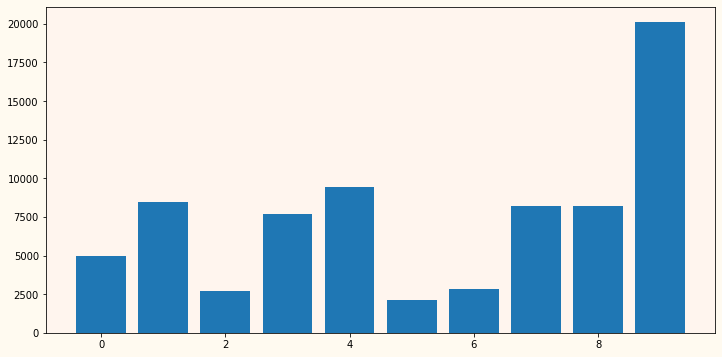

In [ ]:
nsample = []
for cl in range(nClasses) :
  mask = np.argmax(yTrain, axis=1) == cl    # Маска на класс
  nsample.append(xTrain[mask].shape[0])
print(nsample)
  
fig, ax = plt.subplots()
x = [i for i in range(nClasses)]
ax.bar(x, nsample)
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Разбиваем датасет на тренировочный и тестовый при помощи функции train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(xTrain, yTrain, test_size=0.2)

# Первый вариант сети

 
*   Сеть построена на основе сверточных слоёв Керас.
*  Использовано две параллельные ветви с разным ядром свертки.
*  Имеются пробросы с предпосдеднего блока свертки.


In [ ]:
in0 = Input((71, 71, 3))        # Входной слой для 2-x веток

# для 1-й ветви
x0 = Conv2D(8, (3,3), padding="same", activation="elu")(in0)
x0 = Conv2D(8, (3,3), padding="same", activation="elu")(x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.25)(x0)
x0 = MaxPooling2D(2)(x0)
x0 = Conv2D(16, (3,3), padding="same", activation="elu")(x0)
x0 = Conv2D(16, (3,3), padding="same", activation="elu")(x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.25)(x0)
x0 = MaxPooling2D(2)(x0)
x0_m2 = Flatten()(x0)
x0 = Conv2D(32, (3,3), padding="same", activation="elu")(x0)
x0 = Conv2D(32, (3,3), padding="same", activation="elu")(x0)
x0 = BatchNormalization()(x0)
x0 = MaxPooling2D(2)(x0)
x0 = Conv2D(64, (3,3), padding="same", activation="elu")(x0)
x0 = Conv2D(64, (3,3), padding="same", activation="elu")(x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.25)(x0)
x0 = MaxPooling2D(2)(x0)
x0_m4 = Flatten()(x0)
x0 = Conv2D(64, (3,3), padding="same", activation="elu")(x0)
x0 = Conv2D(64, (3,3), padding="same", activation="elu")(x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.25)(x0)
x0 = MaxPooling2D(2)(x0)
x0 = Flatten()(x0)

# для 2-й ветви  strides=4
x1 = Conv2D(16, (5,5), padding="same", activation="elu")(in0)
x1 = Conv2D(16, (5,5), padding="same", strides=4, activation="elu")(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)
x1_m1 = Flatten()(x1)
x1 = Conv2D(64, (5,5), padding="same", activation="elu")(x1)
x1 = Conv2D(64, (5,5), padding="same", strides=4, activation="elu")(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)
x1 = Flatten()(x1)

# Объедияем блоки
x = concatenate([x0, x1,  x0_m4, x1_m1])

# Полносвязные слои на выходе
x = Dense(1000, activation='relu')(x)
x = Dropout(0.25)(x)

x = Dense(nClasses, activation='softmax')(x)

model = Model(in0, x)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

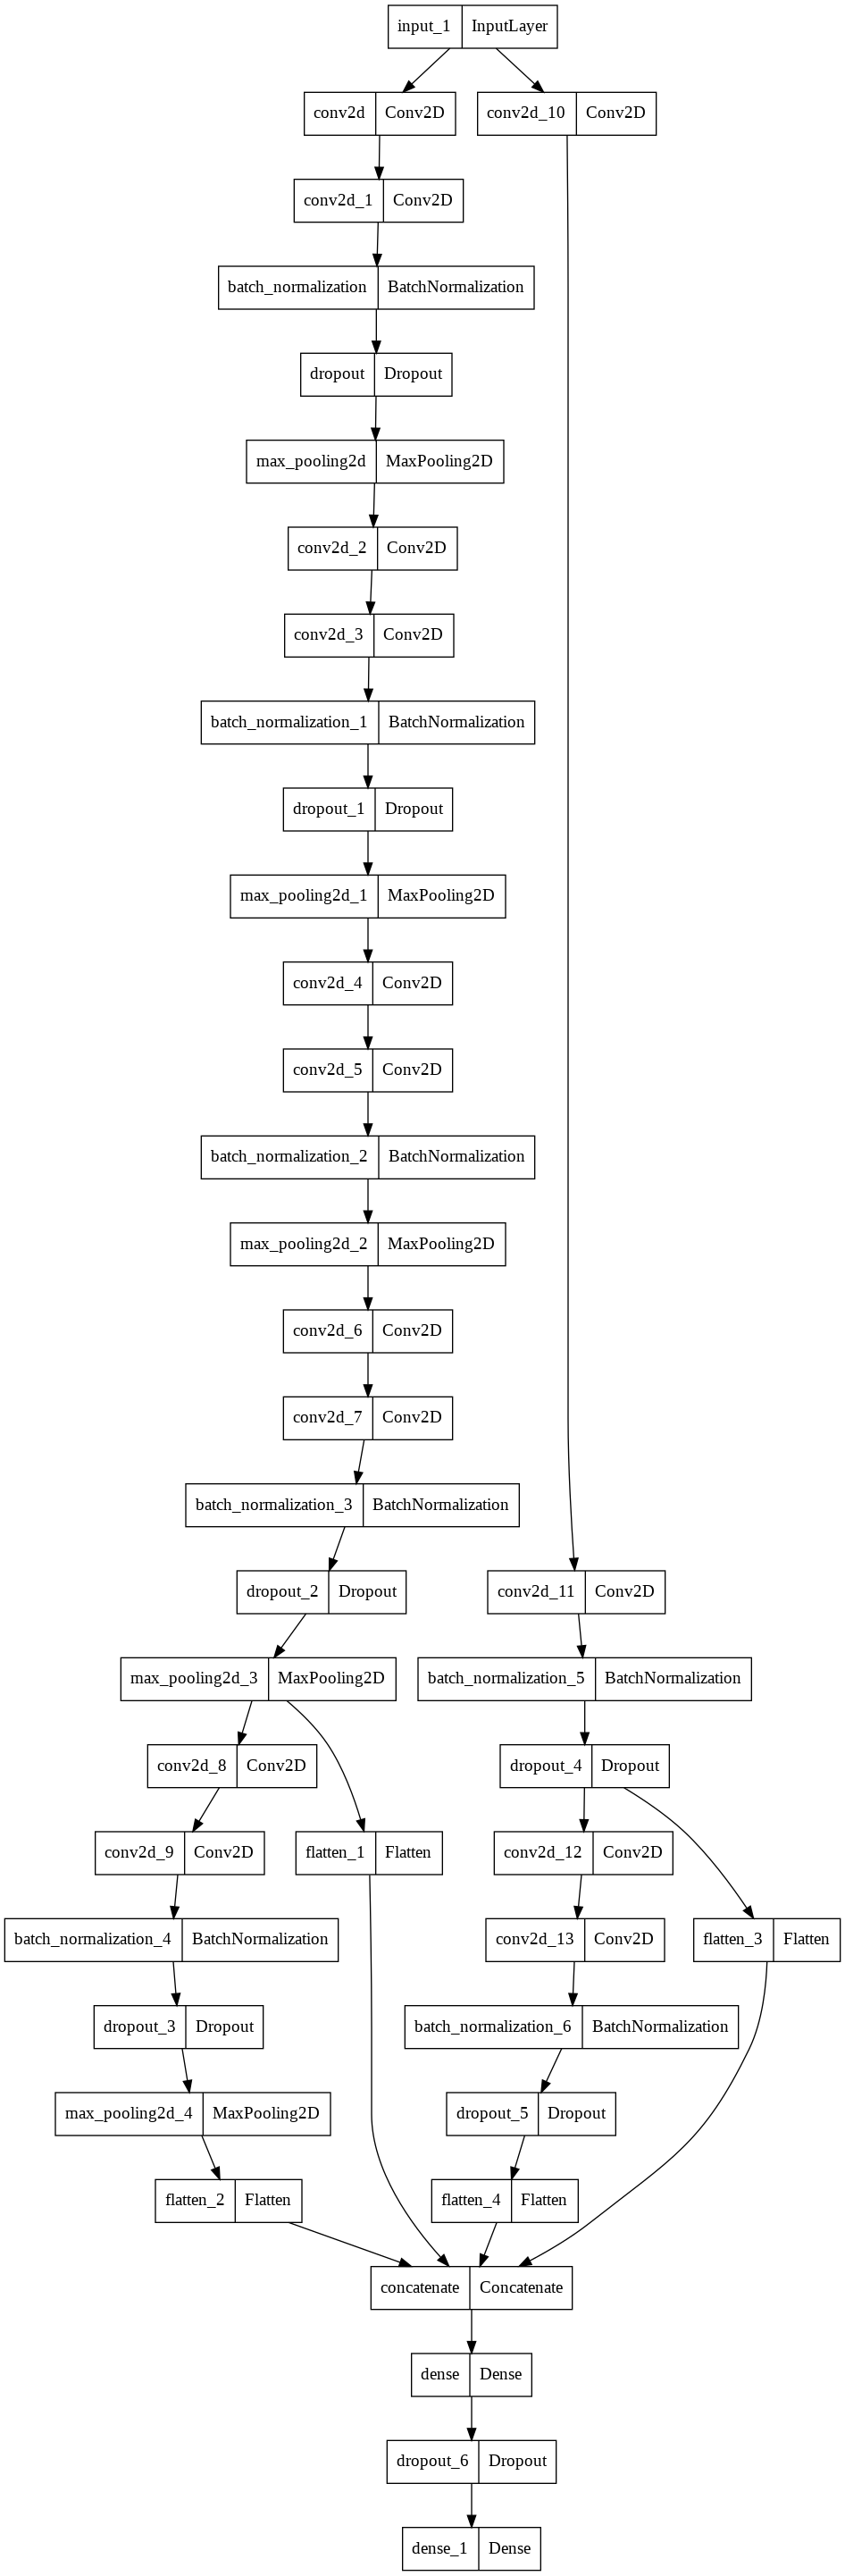

In [ ]:
plot_model(model)

In [ ]:
callbacks = [ModelCheckpoint(filepath='/content/drive/MyDrive/model71.h5',
             verbose=0, save_best_only=True, save_weights_only=False) ]

In [ ]:
history = model.fit(xTrain, yTrain, validation_data=(xTest,  yTest), epochs=5, callbacks=callbacks, batch_size=128)

Epoch 1/5
468/468 [==============================] - 65s 113ms/step - loss: 0.2178 - accuracy: 0.9766 - val_loss: 2.3264 - val_accuracy: 0.7266
Epoch 2/5
468/468 [==============================] - 49s 105ms/step - loss: 0.0110 - accuracy: 0.9969 - val_loss: 3.4973 - val_accuracy: 0.7388
Epoch 3/5
468/468 [==============================] - 49s 105ms/step - loss: 0.0232 - accuracy: 0.9956 - val_loss: 73.0809 - val_accuracy: 0.2852
Epoch 4/5
468/468 [==============================] - 51s 109ms/step - loss: 0.0162 - accuracy: 0.9972 - val_loss: 1.3283 - val_accuracy: 0.8561
Epoch 5/5
468/468 [==============================] - 49s 105ms/step - loss: 0.0212 - accuracy: 0.9971 - val_loss: 4.7555 - val_accuracy: 0.7679


In [ ]:
def lr_scheduler(epoch, lr):
    decay_step = 6
    if epoch % decay_step == 0 and epoch: lr *= 0.1

    return lr

callbacks = [ LearningRateScheduler(lr_scheduler, verbose=0),
              ModelCheckpoint(filepath='/content/drive/MyDrive/model71.h5',
              verbose=0, save_best_only=True, save_weights_only=False)  ]   

In [ ]:
  history = model.fit(xTrain, yTrain, batch_size=128, epochs=10, validation_data=(xTest, yTest),               
                      callbacks=[callbacks], verbose=1, shuffle=True)

Epoch 1/10
468/468 [==============================] - 65s 114ms/step - loss: 0.2359 - accuracy: 0.9734 - val_loss: 1.2229 - val_accuracy: 0.7263 - lr: 0.0010
Epoch 2/10
468/468 [==============================] - 49s 105ms/step - loss: 0.0097 - accuracy: 0.9974 - val_loss: 5.1463 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 3/10
468/468 [==============================] - 51s 108ms/step - loss: 0.0197 - accuracy: 0.9955 - val_loss: 2.1631 - val_accuracy: 0.8321 - lr: 0.0010
Epoch 4/10
468/468 [==============================] - 50s 108ms/step - loss: 0.0202 - accuracy: 0.9966 - val_loss: 0.1565 - val_accuracy: 0.9717 - lr: 0.0010
Epoch 5/10
468/468 [==============================] - 49s 104ms/step - loss: 0.0116 - accuracy: 0.9981 - val_loss: 2.8283 - val_accuracy: 0.8295 - lr: 0.0010
Epoch 6/10
468/468 [==============================] - 50s 107ms/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 0.0242 - val_accuracy: 0.9951 - lr: 0.0010
Epoch 7/10
468/468 [==============================] 

In [ ]:
  history = model.fit(xTrain, yTrain, batch_size=128, epochs=10, validation_data=(xTest, yTest),               
                      callbacks=[callbacks], verbose=1, shuffle=True)

Epoch 1/10
468/468 [==============================] - 63s 110ms/step - loss: 0.1834 - accuracy: 0.9780 - val_loss: 0.2088 - val_accuracy: 0.9226 - lr: 0.0010
Epoch 2/10
468/468 [==============================] - 47s 101ms/step - loss: 0.0159 - accuracy: 0.9963 - val_loss: 1.6573 - val_accuracy: 0.7795 - lr: 0.0010
Epoch 3/10
468/468 [==============================] - 49s 105ms/step - loss: 0.0145 - accuracy: 0.9970 - val_loss: 0.0712 - val_accuracy: 0.9805 - lr: 0.0010
Epoch 4/10
468/468 [==============================] - 48s 102ms/step - loss: 0.0126 - accuracy: 0.9978 - val_loss: 25.2272 - val_accuracy: 0.4338 - lr: 0.0010
Epoch 5/10
468/468 [==============================] - 48s 102ms/step - loss: 0.0254 - accuracy: 0.9964 - val_loss: 0.6817 - val_accuracy: 0.9597 - lr: 0.0010
Epoch 6/10
468/468 [==============================] - 48s 102ms/step - loss: 0.0120 - accuracy: 0.9984 - val_loss: 17.1697 - val_accuracy: 0.4827 - lr: 0.0010
Epoch 7/10
468/468 [==============================

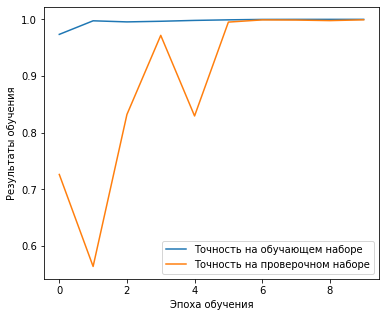

In [ ]:
def gplot(ghist):
  # ghist - history.history
  # График точности обучения
  plt.figure(figsize=(6, 5))
  plt.plot(ghist['accuracy'], label='Точность на обучающем наборе')    
  plt.plot(ghist['val_accuracy'], label='Точность на проверочном наборе')
  #plt.plot(ghist['loss'], label='Ошибка на обучающем наборе')    
  #plt.plot(ghist['val_loss'], label='Ошибка на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Результаты обучения')
  plt.legend()
  plt.show()

gplot(history.history)  

Разбаланс по класам

In [ ]:
for cl in range(nClasses) :
  mask = np.argmax(yTest, axis=1) == cl    # Маска на класс
  print(cl, className[cl])           # Печатаем результат на тестовой выборке
  model.evaluate(xTest[mask], yTest[mask])

0 bag
31/31 [==============================] - 1s 21ms/step - loss: 8.7927e-04 - accuracy: 1.0000
1 bal
53/53 [==============================] - 1s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000
2 ban
17/17 [==============================] - 0s 23ms/step - loss: 3.0430e-05 - accuracy: 1.0000
3 bea
48/48 [==============================] - 1s 16ms/step - loss: 0.0085 - accuracy: 0.9967
4 can
60/60 [==============================] - 1s 15ms/step - loss: 0.0136 - accuracy: 0.9995
5 env
14/14 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000
6 gbt
18/18 [==============================] - 0s 22ms/step - loss: 3.5742e-09 - accuracy: 1.0000
7 mon
52/52 [==============================] - 1s 15ms/step - loss: 2.0777e-07 - accuracy: 1.0000
8 pbt
51/51 [==============================] - 1s 16ms/step - loss: 0.0115 - accuracy: 0.9957
9 toy
128/128 [==============================] - 2s 14ms/step - loss: 7.2325e-07 - accuracy: 1.0000


# Проверим на фото с интернета, камеры

In [ ]:
if os.path.exists('/content/check'): shutil.rmtree('/content/check')
! unzip -q /content/drive/MyDrive/dip/check.zip  # check.zip 

In [ ]:
class CheckLoader():
  def __init__(self, path):
    self.path = path
    self.clName = sorted(os.listdir(path))
    global xVal, yVal
    xVal, yVal = [],[]

  def loadImgFile(self, fPath):           # Загрузка изображения из файла
    return np.array(image.load_img(fPath, target_size=(71,71))).astype('float32')/255     # изображение .  

  def loadImages(self, ncl):              # Загрузка класса
      for n, imfile in enumerate(os.listdir(self.path + self.clName[ncl])):  #  для каждого изображения  
        img = self.loadImgFile(os.path.join(self.path + self.clName[ncl], imfile))
        img = (img - img.min()) / (img.max() - img.min() + 0.01)                     # contrast - max
        #for i in range(2,71): img[:,i,:] =img[:,i,:]/2 + img[:,i-1,:]/4 + img[:,i-2,:]/4

        xVal.append(np.array(img))          # добавим в список обуч.  
        yVal.append(ncl)
  
  def loadDataVal(self):      # Загрузка изображений
    for nc in range(len(self.clName)):
      self.loadImages(nc)     # загрузим избражениЯ
      print(self.clName[nc], end = '   ')
    return self.clName

In [ ]:
dl = CheckLoader('/content/check/')
className = dl.loadDataVal()
del dl
nClasses = len(className)
xVal = np.array(xVal)
yVal = utils.to_categorical(yVal, nClasses)   
print(xVal.shape, yVal.shape) 

bag   bal   ban   bea   can   env   gbt   mon   pbt   toy   (100, 71, 71, 3) (100, 10)


In [ ]:
n = 10 # Количество выводимых случайных картинок
fig, axs = plt.subplots(n, n, figsize=(24, 24)) # Создаем полотно из n*n графиков
for i in range(n): # Проходим по классам
  for j in range(n):
    axs[i,j].imshow(xVal[i*10+j]) # Отображаем фото
plt.show() # Показываем изображения  

In [ ]:
vAccuracy =[]
for cl in range(10) :
  mask = np.argmax(yVal, axis=1) == cl    # Маска на класс
  print(cl, className[cl])           # Печатаем результат на проверочной выборке
  mx = model.evaluate(xVal[mask], yVal[mask])
  vAccuracy.append(mx[1])

0 bag
1/1 [==============================] - 0s 227ms/step - loss: 104.5066 - accuracy: 0.1000
1 bal
1/1 [==============================] - 0s 38ms/step - loss: 20.1629 - accuracy: 0.3000
2 ban
1/1 [==============================] - 0s 36ms/step - loss: 48.9943 - accuracy: 0.3000
3 bea
1/1 [==============================] - 0s 45ms/step - loss: 2.5640 - accuracy: 0.8000
4 can
1/1 [==============================] - 0s 42ms/step - loss: 36.0944 - accuracy: 0.3000
5 env
1/1 [==============================] - 0s 29ms/step - loss: 39.4729 - accuracy: 0.2000
6 gbt
1/1 [==============================] - 0s 31ms/step - loss: 30.9011 - accuracy: 0.1000
7 mon
1/1 [==============================] - 0s 30ms/step - loss: 67.2919 - accuracy: 0.0000e+00
8 pbt
1/1 [==============================] - 0s 37ms/step - loss: 53.4880 - accuracy: 0.1000
9 toy
1/1 [==============================] - 0s 30ms/step - loss: 4.4360 - accuracy: 0.7000


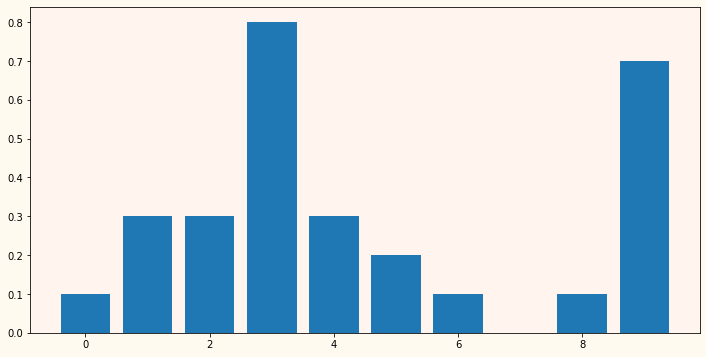

In [ ]:

fig, ax = plt.subplots()
x = [i for i in range(nClasses)]
ax.bar(x, vAccuracy)
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
plt.show()

# Выводы:

1. Присутствует неравномерное распределение примеров по категориям.

2. Сеть распознает примеры из валидационной выборки очень хорошо.

3. Распознавания изображений из интернета или камеры - практически нет.